In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv('Software Engineer Salaries.csv')
df.head()

,Company,Company Score,Job Title,Location,Date,Salary
0,ViewSoft,4.8,Software Engineer,"Manassas, VA",8d,$68K - $94K (Glassdoor est.)
1,Workiva,4.3,Software Support Engineer,Remote,2d,$61K - $104K (Employer est.)
2,"Garmin International, Inc.",3.9,C# Software Engineer,"Cary, NC",2d,$95K - $118K (Glassdoor est.)
3,Snapchat,3.5,"Software Engineer, Fullstack, 1+ Years of Expe...","Los Angeles, CA",2d,$97K - $145K (Employer est.)
4,Vitesco Technologies Group AG,3.1,Software Engineer,"Seguin, TX",2d,$85K - $108K (Glassdoor est.)


<Axes: xlabel='Company Score', ylabel='Count'>

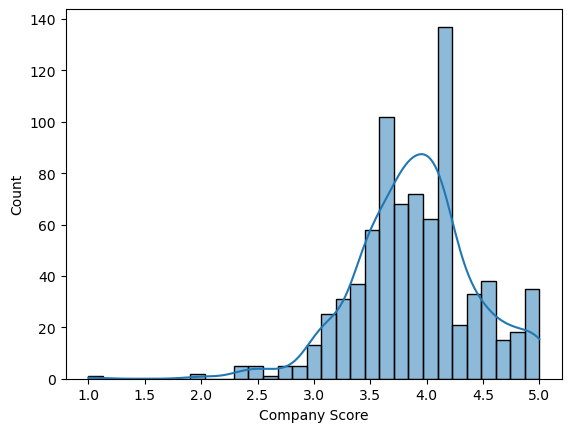

In [3]:
sns.histplot(data=df['Company Score'], kde=True)

<Axes: ylabel='Company Score'>

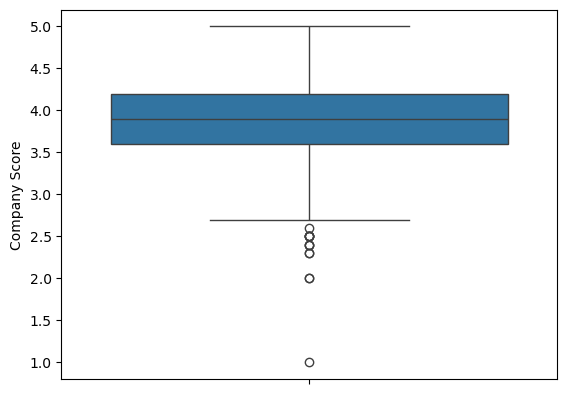

In [4]:
sns.boxplot(data=df['Company Score'])

<Axes: ylabel='Job Title'>

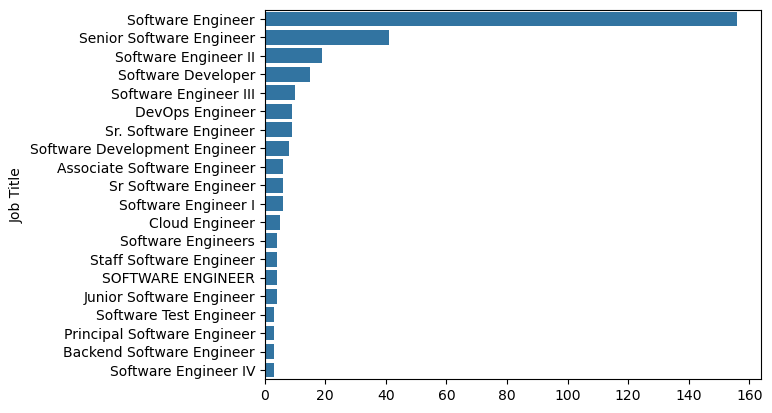

In [5]:
job_title_counts = df['Job Title'].value_counts()

top_20_titles = job_title_counts.head(20)

sns.barplot(x=top_20_titles.values, y=top_20_titles.index, orient='h')

### Explanations

- the distribution of company score is positively skewed
- there are several outliers, and the distribution variability is high, while median seems to be around 4
- the number of position of software engineer is far more than other jobs

In [10]:
# detect outliers

# out of 1.5*IQR range are outliers (boxplot)
def detect_outliers(column):
    Q1 = column.quantile(0.25)
    Q3 = column.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return (column >= lower_bound) | (column <= upper_bound)

In [11]:
# since outliers does not count many 
# and there are no extra info to decide whether it is ok to delete rows with ouliers (since company score that is too high might indeed be not true)
# we will delete outliers

nonoutliers_company_score = detect_outliers(df['Company Score'])

df = df[nonoutliers_company_score]

In [12]:
columns_with_missing = df.columns[df.isnull().any()].tolist()

print("Columns with missing values:", columns_with_missing)

Columns with missing values: ['Location', 'Salary']


In [13]:
for col in columns_with_missing:
    mode_value = df[col].mode()[0] 
    df[col] = df[col].fillna(mode_value)
# fill with mode (though might not rigorous, but based on prnciple not delete enties easily, and the location & salary will not change much in this missing value count)_

print("Columns with missing values after filling:", df.columns[df.isnull().any()].tolist())

Columns with missing values after filling: []


## Steps in missing and outliers handling

- the outliers are identiffied based on box plot quantile cutoff values.
- the missing value are identified by .isnull(), which might have limitation in some case where missing values are not expressed as NAN standard form
- rows with outliers are deleted, not only due to reason in comment, but also because the outliers will natually japrodize the ML algorithm performance by adding instability factor in training process. 
- missing values are filled with mode, which is explained in comments.

In [15]:
# here we need to use function to convert the last column format into numerical values
# revised
def split_salary_col(val):
    
    if pd.isna(val):
        return 'Unknown', 'Unknown', 0, 0

    val = str(val).lower().replace('$', '').strip()

    if 'glassdoor est.' in val:
        data_source = 'glassdoor'
    elif 'employer est.' in val:
        data_source = 'employer'
    else:
        data_source = 'Unknown'

    pay = 'hourly' if 'per hour' in val else 'salary'

    val = val.replace('(glassdoor est.)', '').replace('(employer est.)', '').replace('per hour', '').strip()

    temp = val.split('-')
    if len(temp) == 1:
        temp.append(temp[0])

    def parse_value(v):
        v = v.strip().replace('k', '000').replace('m', '000000')
        return float(v) if v else 0

    return data_source, pay, parse_value(temp[0]), parse_value(temp[1])

# revised version with less lines of code from calss example

In [26]:
# apply this to df
df['data_source'], df['pay_type'], df['base_salary'], df['max_salary'] = zip(*df['Salary'].apply(split_salary_col))

df['salary_range'] = df['max_salary'] - df['base_salary']

base_salary_mean = df['base_salary'].mean()
base_salary_median = df['base_salary'].median()
base_salary_std = df['base_salary'].std()

salary_range_mean = df['salary_range'].mean()
salary_range_median = df['salary_range'].median()
salary_range_std = df['salary_range'].std()

base_salary_mode = df['base_salary'].mode().values
salary_range_mode = df['salary_range'].mode().values
company_score_mode = df['Company Score'].mode().values

company_score_mean = df['Company Score'].mean()
company_score_median = df['Company Score'].median()
company_score_std = df['Company Score'].std()

In [27]:
# print them to have a peek
print("Base Salary Statistics:")
print("Mean: $" + str(round(base_salary_mean, 2)))
print("Median: $" + str(round(base_salary_median, 2)))
print("Standard Deviation: $" + str(round(base_salary_std, 2)))

print("\nSalary Range Statistics:")
print("Mean: $" + str(round(salary_range_mean, 2)))
print("Median: $" + str(round(salary_range_median, 2)))
print("Standard Deviation: $" + str(round(salary_range_std, 2)))

# For mode, we'll use a simple loop
print("\nBase Salary Mode:")
for value in base_salary_mode:
    print("$" + str(round(value, 2)))

print("Salary Range Mode:")
for value in salary_range_mode:
    print("$" + str(round(value, 2)))

print("\nCompany Score Statistics:")
print("Mean: " + str(round(company_score_mean, 2)))

print("Median: " + str(round(company_score_median, 2)))
print("Standard Deviation: " + str(round(company_score_std, 2)))
print("\nCompany Score Mode:")
for value in company_score_mode:
    print(str(round(value, 2)))


Base Salary Statistics:
Mean: $101344.0
Median: $95000.0
Standard Deviation: $40412.89

Salary Range Statistics:
Mean: $48293.01
Median: $40000.0
Standard Deviation: $36002.0

Base Salary Mode:
$120000.0
Salary Range Mode:
$30000.0

Company Score Statistics:
Mean: 3.9
Median: 3.9
Standard Deviation: 0.52

Company Score Mode:
4.1


In [18]:
# see the source, salary type

grouped_counts = df.groupby(['pay_type', 'data_source']).size().reset_index(name='count')

print("Counts by Pay Type and Data Source:")
print(grouped_counts)

Counts by Pay Type and Data Source:
  pay_type data_source  count
0   hourly    employer     24
1   salary    employer    437
2   salary   glassdoor    328


### Insights about the dataset

| Variable       | Mean   | Median | Mode   | Std    | Source    | Salary_Type |
| -------------- | ------ | ------ | ------ | ------ | --------- | ----------- |
| Company Score  | 3.9    |   3.9  |   4.1  |  0.52  |           |             |
| Base Salary    | 101344 | 95000  | 120000 | 40413  |           |             |
| Salary Range   | 48293  | 40000  | 30000  | 36002  |           |             |
| 24             |        |        |        |        | hourly    | employer    |
| 437            |        |        |        |        | salary    | employer    |
| 328            |        |        |        |        | salary    | glassdoor   |

- this industry indeed is highly paid, and employee satisfaction is mostly high.
- wide salary range indicate large potential in each position
- Some very high earners skewing averages
- Set pay levels with common stopping points


In [21]:
df.head()

,Company,Company Score,Job Title,Location,Date,Salary,data_source,pay_type,base_salary,max_salary,salary_range
0,ViewSoft,4.8,Software Engineer,"Manassas, VA",8d,$68K - $94K (Glassdoor est.),glassdoor,salary,68000.0,94000.0,26000.0
1,Workiva,4.3,Software Support Engineer,Remote,2d,$61K - $104K (Employer est.),employer,salary,61000.0,104000.0,43000.0
2,"Garmin International, Inc.",3.9,C# Software Engineer,"Cary, NC",2d,$95K - $118K (Glassdoor est.),glassdoor,salary,95000.0,118000.0,23000.0
3,Snapchat,3.5,"Software Engineer, Fullstack, 1+ Years of Expe...","Los Angeles, CA",2d,$97K - $145K (Employer est.),employer,salary,97000.0,145000.0,48000.0
4,Vitesco Technologies Group AG,3.1,Software Engineer,"Seguin, TX",2d,$85K - $108K (Glassdoor est.),glassdoor,salary,85000.0,108000.0,23000.0


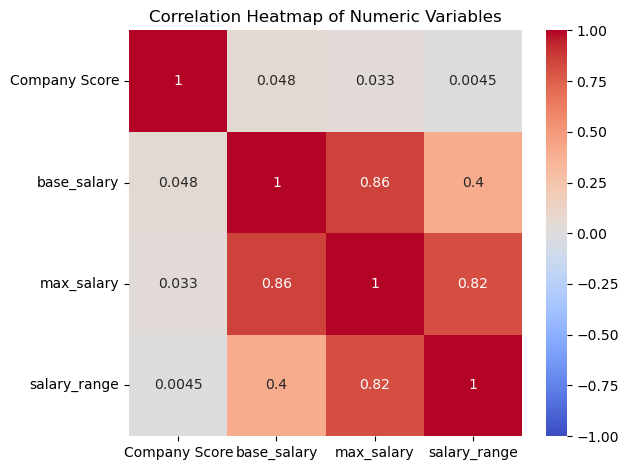

In [22]:
numeric_columns = ['Company Score', 'base_salary', 'max_salary', 'salary_range']
correlation_matrix = df[numeric_columns].corr() 

sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Correlation Heatmap of Numeric Variables')
plt.tight_layout()

### Key Insights found

__Correlations between variables are weak in all, the high correlation beteen base and max salary is obvious and can only show the variability is not too high relative to base salary, which is common sense.__

- the range and base correlation is medimum even low (<0.5), but still reflect that position with hight startup will have higher potential.
- weak correlation between company score and salary level indicates better company(at least more favored) would have same hierachy and salary distribution with those worse. Same may not be applied to differece in company scale, business field, etc, while in this case there is not enough info to tell (unless it is believed larger company would be less welcomed& rated)


# Final Summary

The data reveals a thriving software engineering job market with generally high salaries and positive company ratings. The average base salary is around $101,000, with a median of $95,000, indicating ldollar-earning opportunities across the field. Company scores cluster between 3.5-4.5 out of 5, suggesting overall job satisfaction.  

 There's only a weak correlation between company ratings and salaries. This implies that well-regarded companies exist across the salary spectrum, and high pay doesn't necessarily equate to better job satisfaction.  

The dataset shows diverse roles within software engineering, from entry-level to senior positions, with varying specializations like DevOps and development engineering. There's a wide salary range, reflecting the impact of factors such as experience, location, and specific job requirements.
Location appears influential, with tech hubs likely offering higher salaries. However, the presence of remote positions indicates flexibility in work arrangements.  

Data sources include both Glassdoor estimates and employer listings, predominantly for salaried positions. Some exceptionally high salaries skew the averages upward, highlighting potential for substantial earnings in the field.  

Overall, the analysis paints a picture of a thriving industry with satisfied employees and diverse opportunities. It suggests that job seekers in software engineering might find fulfilling roles across various salary levels, emphasizing the importance of considering factors beyond just pay when job hunting.  